# Iteration 17th

## $R^2$ calculation

In [1]:
from sklearn.linear_model import LinearRegression
import numpy as np

sigma      = y_test.ravel()   # true values
sigma_hat  = y_pred.ravel()   # predicted values

# Fit σ  = β₀ + β₁·σ_hat
linreg = LinearRegression()
linreg.fit(sigma_hat.reshape(-1, 1), sigma)

r_squared = linreg.score(sigma_hat.reshape(-1, 1), sigma)
beta_0    = linreg.intercept_  
beta_1    = linreg.coef_[0]   

print(f"Linear-fit R² : {r_squared:.4f}")
print(f"β₀ (intercept): {beta_0:.6f}")
print(f"β₁ (slope)    : {beta_1:.6f}")


NameError: name 'y_test' is not defined

## EMD vol model

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    r2_score
)

from PyEMD import EMD
from scipy.signal import hilbert

import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
# 1) Load & scale
df = pd.read_csv('../../data/dataV.csv', parse_dates=['Date'])
df.sort_values('Date', inplace=True, ignore_index=True)
X_raw = df[['volatility']].values    # shape (T,1)
y_raw = df[['volatility_forcast']].values  # shape (T,1)

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X_raw)
y_scaled = scaler_y.fit_transform(y_raw).flatten()  # make it (T,) for easier indexing


In [3]:
# 2) Compute EMD‐based window sizes τₜ
max_W = 20
emd     = EMD()

imfs    = emd.emd(X_scaled.flatten())    # must pass a 1-D array
all_amp = [ np.abs(hilbert(imf)) for imf in imfs ]
all_pow = [ amp**2 for amp in all_amp ]
energies = [ p.mean() for p in all_pow ]

inst_power_norm = np.zeros_like(X_scaled.flatten(), dtype=float)
for p, E in zip(all_pow, energies):
    inst_power_norm += (p / E)

tau_emd = np.clip(np.round(inst_power_norm).astype(int), 1, max_W)
print("first 20 EMD windows:", tau_emd[:20])


first 20 EMD windows: [20 20 20 20 19 17 17 14 15 14 13 12 12 11 12 12 12 12 12 11]


In [4]:
# --- 3) Build dynamic sequences + mask, now also returning the original row‐indices ---
def create_dynamic_sequences_with_mask(X, y, tau, max_len):
    Xs, masks, ys, idxs = [], [], [], []
    T, D = X.shape
    for t in range(T):
        w = tau[t]
        if t < w:
            continue

        window = X[t-w : t]       # shape (w, D)
        m      = np.ones((w,1))
        if w < max_len:
            pad_X = np.zeros((max_len - w, D))
            pad_m = np.zeros((max_len - w, 1))
            window = np.vstack([pad_X, window])
            m      = np.vstack([pad_m,    m     ])

        Xs.append(window)         # → (max_len, D)
        masks.append(m)           # → (max_len, 1)
        ys.append(y[t])           # scalar target
        idxs.append(t)            # record that this sample “ends” at original row t
    return np.stack(Xs), np.stack(masks), np.array(ys), np.array(idxs)

X_dyn, M_dyn, y_dyn, idx_dyn = create_dynamic_sequences_with_mask(
    X_scaled,    # (T,1)
    y_scaled,    # (T,)
    tau_emd,     # (T,)
    max_W        # scalar
)

print("X_dyn:", X_dyn.shape, "M_dyn:", M_dyn.shape, "y_dyn:", y_dyn.shape)
# X_dyn = (N, max_W, D), M_dyn = (N, max_W, 1), y_dyn = (N,)


X_dyn: (5285, 20, 1) M_dyn: (5285, 20, 1) y_dyn: (5285,)


In [5]:
# 4) Concatenate mask as extra feature
X_with_mask = np.concatenate([X_dyn, M_dyn], axis=2)
# now shape = (N, max_W, D+1)

In [6]:
# --- 5) Train/test split, now also splitting idx_dyn to get test_idx ---

X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X_with_mask,    # features
    y_dyn,          # targets
    idx_dyn,        # row‐indices in df
    test_size=0.2,
    shuffle=False
)


In [7]:
# 6) Broadcast each scalar target into a seq‐length long vector
def build_y_seqs(y_flat, seq_length):
    N = len(y_flat)
    Y = np.zeros((N, seq_length, 1))
    for i, val in enumerate(y_flat):
        Y[i, :, 0] = val
    return Y

Y_train = build_y_seqs(y_train, max_W)
Y_test  = build_y_seqs(y_test,  max_W)

In [8]:

class MaskedLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, output_dim):
        """
        Same API as before:
          - input_dim   = D (number of “real” features per time step)
          - hidden_dim1 = 256
          - hidden_dim2 = 128
          - output_dim  = 1

        Internally, we just stack two nn.LSTMCell modules, and before
        each time step we “hard‐forget” by multiplying h and c by mask_t.
        """
        super().__init__()
        self.input_dim  = input_dim
        self.hidden_dim1 = hidden_dim1
        self.hidden_dim2 = hidden_dim2
        self.output_dim = output_dim

        # Layer‐1: input→256
        self.cell1 = nn.LSTMCell(input_dim, hidden_dim1)
        # Layer‐2: 256→128
        self.cell2 = nn.LSTMCell(hidden_dim1, hidden_dim2)
        # Final linear: 128→output_dim
        self.out   = nn.Linear(hidden_dim2, output_dim)

    def forward(self, x_with_mask):
        """
        x_with_mask: (batch, seq_len, input_dim+1)
          – last channel is the 0/1 mask
          – first input_dim channels are the “real” features.
        Returns: y_preds of shape (batch, seq_len, output_dim)
        """
        batch, seq_len, Dp = x_with_mask.size()
        assert Dp == self.input_dim + 1

        data = x_with_mask[:, :, :-1]  # (batch, seq_len, input_dim)
        mask = x_with_mask[:, :, -1:]  # (batch, seq_len, 1)

        # initialize h1,c1 and h2,c2 to zero:
        h1 = data.new_zeros(batch, self.hidden_dim1)
        c1 = data.new_zeros(batch, self.hidden_dim1)
        h2 = data.new_zeros(batch, self.hidden_dim2)
        c2 = data.new_zeros(batch, self.hidden_dim2)

        outs = []
        for t in range(seq_len):
            x_t = data[:, t, :]     # (batch, input_dim)
            m_t = mask[:, t, :]     # (batch, 1); either 0.0 or 1.0

            # —— Layer 1 “hard‐forget” step:
            h1 = h1 * m_t
            c1 = c1 * m_t
            # then run the built-in LSTMCell once:
            h1, c1 = self.cell1(x_t, (h1, c1))

            # —— Layer 2 “hard‐forget” step:
            h2 = h2 * m_t
            c2 = c2 * m_t
            # feed the *output* of layer1 into layer2:
            h2, c2 = self.cell2(h1, (h2, c2))

            # finally compute y_t = Linear(h2)
            y_t = self.out(h2)            # (batch, output_dim)
            outs.append(y_t.unsqueeze(1)) # keep a time dimension

        # stack over time → (batch, seq_len, output_dim)
        return torch.cat(outs, dim=1)

In [9]:
# 8) Prepare data → move to torch.Tensor; define optimizer & loss
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Convert numpy to torch, move to device
X_train_t = torch.from_numpy(X_train).float().to(device)  # (N_train, seq_len, D+1)
Y_train_t = torch.from_numpy(Y_train).float().to(device)  # (N_train, seq_len, 1)
X_test_t  = torch.from_numpy(X_test) .float().to(device)  # (N_test,  seq_len, D+1)
Y_test_t  = torch.from_numpy(Y_test) .float().to(device)  # (N_test,  seq_len, 1)

# Instantiate the bigger model:
#   – input_dim  = D  = X_train.shape[2] - 1
#   – hidden_dim1 = 256
#   – hidden_dim2 = 128
#   – output_dim = 1
model = MaskedLSTM(
    input_dim   = X_train.shape[2] - 1,
    hidden_dim1 = 100,
    hidden_dim2 = 48,
    output_dim  = 1
).to(device)

optimizer = optim.Adam(model.parameters(), lr=5e-3)
criterion = nn.MSELoss()


In [10]:
# 9) Training loop
num_epochs = 100
batch_size = 152
N_train = X_train_t.size(0)

for epoch in range(1, num_epochs+1):
    perm = torch.randperm(N_train, device=device)
    X_perm = X_train_t[perm]
    Y_perm = Y_train_t[perm]

    running_loss = 0.0
    num_batches = math.ceil(N_train / batch_size)

    for i in range(0, N_train, batch_size):
        xb = X_perm[i : i+batch_size]   # (b, seq_len, D+1)
        yb = Y_perm[i : i+batch_size]   # (b, seq_len, 1)

        optimizer.zero_grad()
        preds = model(xb)               # (b, seq_len, 1)
        loss  = criterion(preds, yb)    # MSE over all time steps
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_train_loss = running_loss / num_batches

    # Validation loss:
    with torch.no_grad():
        val_preds = model(X_test_t)                     # (N_test, seq_len, 1)
        val_loss = criterion(val_preds, Y_test_t).item()

    print(f"Epoch {epoch}/{num_epochs} — train MSE: {avg_train_loss:.6f} — val MSE: {val_loss:.6f}")



Epoch 1/100 — train MSE: 0.006449 — val MSE: 0.004143
Epoch 2/100 — train MSE: 0.005491 — val MSE: 0.004101
Epoch 3/100 — train MSE: 0.005217 — val MSE: 0.003993
Epoch 4/100 — train MSE: 0.005217 — val MSE: 0.004437
Epoch 5/100 — train MSE: 0.005210 — val MSE: 0.004235
Epoch 6/100 — train MSE: 0.005141 — val MSE: 0.003777
Epoch 7/100 — train MSE: 0.005187 — val MSE: 0.004246
Epoch 8/100 — train MSE: 0.005236 — val MSE: 0.004095
Epoch 9/100 — train MSE: 0.005235 — val MSE: 0.004125
Epoch 10/100 — train MSE: 0.005175 — val MSE: 0.004043
Epoch 11/100 — train MSE: 0.005194 — val MSE: 0.003790
Epoch 12/100 — train MSE: 0.005249 — val MSE: 0.004326
Epoch 13/100 — train MSE: 0.005266 — val MSE: 0.004293
Epoch 14/100 — train MSE: 0.005113 — val MSE: 0.004079
Epoch 15/100 — train MSE: 0.005141 — val MSE: 0.004074
Epoch 16/100 — train MSE: 0.005182 — val MSE: 0.003955
Epoch 17/100 — train MSE: 0.005146 — val MSE: 0.003841
Epoch 18/100 — train MSE: 0.005094 — val MSE: 0.004245
Epoch 19/100 — trai

In [11]:
# 10) Predict & evaluate
with torch.no_grad():
    preds_seq_t = model(X_test_t)       # (N_test, seq_len, 1)
    preds_last_t = preds_seq_t[:, -1, 0]  # (N_test,)
    y_last_t     = Y_test_t[:, -1, 0]     # (N_test,)

preds_last = preds_last_t.cpu().numpy().reshape(-1,1)
y_last     = y_last_t    .cpu().numpy().reshape(-1,1)

preds_inv = scaler_y.inverse_transform(preds_last).flatten()
y_inv     = scaler_y.inverse_transform(y_last)    .flatten()

mse  = mean_squared_error(y_inv, preds_inv)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_inv, preds_inv)
mape = mean_absolute_percentage_error(y_inv, preds_inv)
r2   = r2_score(y_inv, preds_inv)

print(f"\nTest MSE={mse:.6f}  RMSE={rmse:.6f}  MAE={mae:.6f}")
print(f"     MAPE={100*mape:.2f}%  R²={r2:.4f}")



Test MSE=0.368598  RMSE=0.607122  MAE=0.457392
     MAPE=48.15%  R²=0.3037


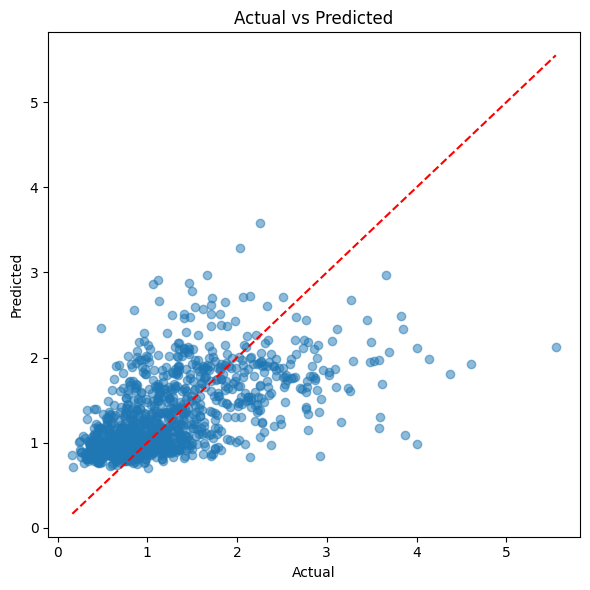

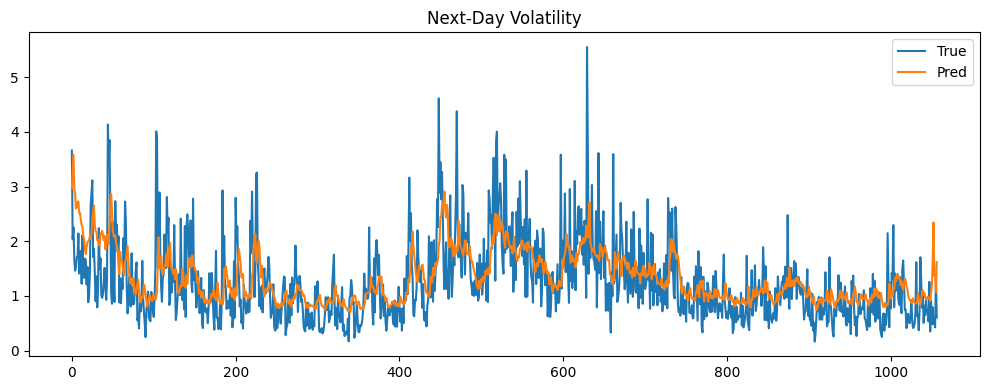

In [12]:
# 11) Quick plots (unchanged)
plt.figure(figsize=(6,6))
plt.scatter(y_inv, preds_inv, alpha=0.5)
lims = [
    min(y_inv.min(), preds_inv.min()),
    max(y_inv.max(), preds_inv.max())
]
plt.plot(lims, lims, 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(y_inv,    label='True')
plt.plot(preds_inv, label='Pred')
plt.legend()
plt.title("Next-Day Volatility")
plt.tight_layout()
plt.show()


Saving (optionnal)

In [13]:
# 11) Write back into df
df['vol_LSTM'] = np.nan
df.loc[idx_test, 'vol_LSTM'] = preds_inv

# 12) Optionally save out
df.to_csv('../../data/dataV.csv', index=False)

In [14]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

## Probabilistic model

In [15]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [16]:
df = pd.read_csv('../../data/dataV.csv', parse_dates=['Date'])
df.sort_values('Date', inplace=True, ignore_index=True)


In [17]:
# 2) Compute features + targets
df['returns_sd']          = df['volatility'].expanding().std(ddof=10)
df['returns_sd_mean']     = df['returns_sd'].expanding().mean()
df['returns_sd_target']      = df['returns_sd'].shift(-1)
df['returns_sd_mean_target'] = df['returns_sd_mean'].shift(-1)

# 3) Drop *every* row that has any NaN in our columns of interest
cols = ['returns','returns_sd','returns_sd_mean',
        'returns_sd_target','returns_sd_mean_target']
df = df.dropna(subset=cols).reset_index(drop=True)

# 4) Verify no NaNs remain
assert not df[cols].isna().any().any(), "There are still NaNs!"


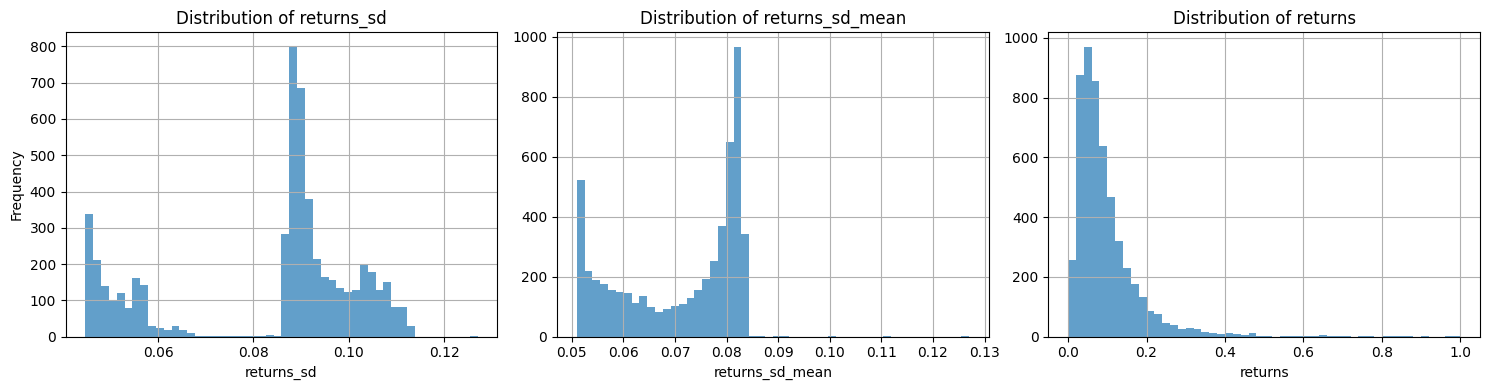

In [18]:
# 8) Plot distributions of the three features
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# returns_sd
axes[0].hist(df['returns_sd'], bins=50, alpha=0.7)
axes[0].set_title('Distribution of returns_sd')
axes[0].set_xlabel('returns_sd')
axes[0].set_ylabel('Frequency')
axes[0].grid(True)

# returns_sd_mean
axes[1].hist(df['returns_sd_mean'], bins=50, alpha=0.7)
axes[1].set_title('Distribution of returns_sd_mean')
axes[1].set_xlabel('returns_sd_mean')
axes[1].grid(True)

# returns
axes[2].hist(df['volatility'], bins=50, alpha=0.7)
axes[2].set_title('Distribution of returns')
axes[2].set_xlabel('returns')
axes[2].grid(True)

plt.tight_layout()
plt.show()

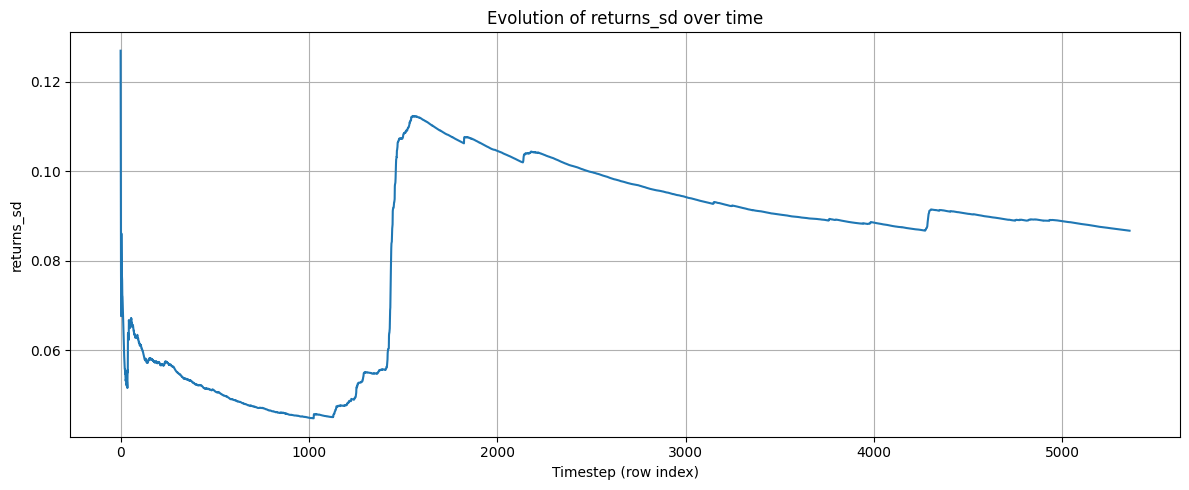

In [19]:
plt.figure(figsize=(12, 5))
plt.plot(df.index, df['returns_sd'])
plt.title('Evolution of returns_sd over time')
plt.xlabel('Timestep (row index)')
plt.ylabel('returns_sd')
plt.grid(True)
plt.tight_layout()
plt.show()


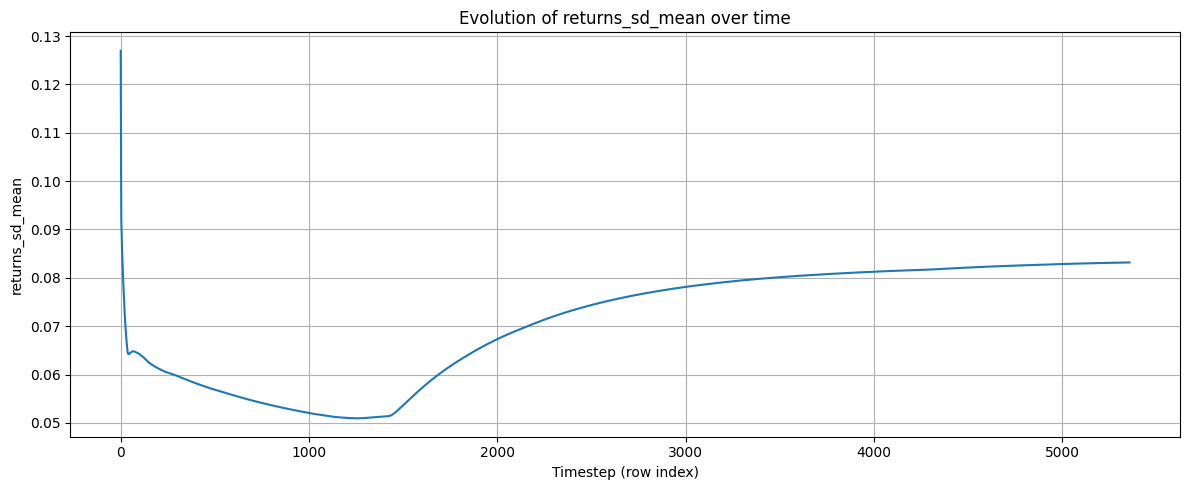

In [20]:
plt.figure(figsize=(12, 5))
plt.plot(df.index, df['returns_sd_mean'])
plt.title('Evolution of returns_sd_mean over time')
plt.xlabel('Timestep (row index)')
plt.ylabel('returns_sd_mean')
plt.grid(True)
plt.tight_layout()
plt.show()


In [21]:
# 2) Dataset & DataLoader
class SequenceDataset(Dataset):
    def __init__(self, df, seq_len=10):
        self.X = df[['returns_sd','returns','returns_sd_mean']].values.astype(np.float32)
        self.y = df[['returns_sd_target','returns_sd_mean_target']].values.astype(np.float32)
        self.seq_len = seq_len

    def __len__(self):
        return len(self.X) - self.seq_len

    def __getitem__(self, idx):
        x_seq = self.X[idx:idx + self.seq_len]
        y_target = self.y[idx + self.seq_len]
        return (
            torch.from_numpy(x_seq),
            torch.from_numpy(y_target),
        )

seq_len   = 10
batch_sz  = 32
dataset   = SequenceDataset(df, seq_len=seq_len)
loader    = DataLoader(dataset, batch_size=batch_sz, shuffle=True)


In [22]:

# 3) Model
class LSTMForecast(nn.Module):
    def __init__(self, input_size=3, hidden1=64, hidden2=32, output_size=2):
        super().__init__()
        # first LSTM layer
        self.lstm1 = nn.LSTM(input_size, hidden1, batch_first=True)
        # second LSTM layer
        self.lstm2 = nn.LSTM(hidden1, hidden2, batch_first=True)
        # final linear to 2 targets
        self.lin   = nn.Linear(hidden2, output_size)

    def forward(self, x):
        # x: [batch, seq_len, input_size]
        out, _ = self.lstm1(x)       # → [batch, seq_len, hidden1]
        out, _ = self.lstm2(out)     # → [batch, seq_len, hidden2]
        out = out[:, -1, :]          # take last timestep → [batch, hidden2]
        return self.lin(out)         # → [batch, output_size]

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model  = LSTMForecast().to(device)
opt    = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn= nn.MSELoss()

In [23]:
# 4) Training loop
epochs = 20
for epoch in range(1, epochs+1):
    model.train()
    total_loss = 0.0
    for x_batch, y_batch in loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        preds = model(x_batch)
        loss  = loss_fn(preds, y_batch)
        opt.zero_grad()
        loss.backward()
        opt.step()
        total_loss += loss.item() * x_batch.size(0)
    avg_loss = total_loss / len(loader.dataset)
    print(f"Epoch {epoch:02d} — train MSE: {avg_loss:.6f}")

Epoch 01 — train MSE: 0.001163
Epoch 02 — train MSE: 0.000236
Epoch 03 — train MSE: 0.000115
Epoch 04 — train MSE: 0.000039
Epoch 05 — train MSE: 0.000036
Epoch 06 — train MSE: 0.000030
Epoch 07 — train MSE: 0.000019
Epoch 08 — train MSE: 0.000002
Epoch 09 — train MSE: 0.000001
Epoch 10 — train MSE: 0.000001
Epoch 11 — train MSE: 0.000001
Epoch 12 — train MSE: 0.000001
Epoch 13 — train MSE: 0.000002
Epoch 14 — train MSE: 0.000002
Epoch 15 — train MSE: 0.000002
Epoch 16 — train MSE: 0.000001
Epoch 17 — train MSE: 0.000001
Epoch 18 — train MSE: 0.000001
Epoch 19 — train MSE: 0.000001
Epoch 20 — train MSE: 0.000001


In [24]:

# --- 6) Inference over your whole dataset for plotting ---
model.eval()
all_preds, all_actuals = [], []

# create a fresh loader with shuffle=False so order matches
infer_loader = DataLoader(dataset, batch_size=32, shuffle=False)

with torch.no_grad():
    for x_batch, y_batch in infer_loader:
        x_batch = x_batch.to(device)
        preds = model(x_batch).cpu().numpy()        # shape (batch, 2)
        all_preds.append(preds)
        all_actuals.append(y_batch.numpy())         # shape (batch, 2)

# stack into (N,2) arrays
all_preds   = np.vstack(all_preds)
all_actuals = np.vstack(all_actuals)


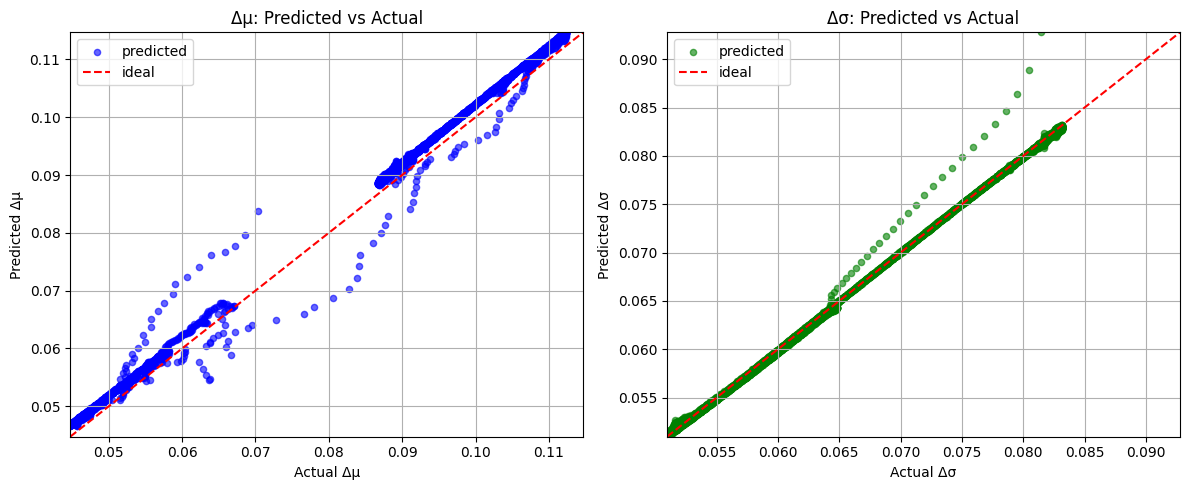

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# --- 7) Plot predicted vs actual side by side ---
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Left: returns_sd_target (Δσ)
x0 = all_actuals[:, 0]   # true returns_sd_target
y0 = all_preds[:,     0] # pred returns_sd_target
lims0 = (min(x0.min(), y0.min()), max(x0.max(), y0.max()))

axes[0].scatter(x0, y0, s=20, alpha=0.6, color='blue', label='predicted')
axes[0].plot(lims0, lims0, '--', color='red', label='ideal')
axes[0].set_title(r'Δμ: Predicted vs Actual')
axes[0].set_xlabel(r'Actual Δμ')
axes[0].set_ylabel(r'Predicted Δμ')
axes[0].set_xlim(lims0)
axes[0].set_ylim(lims0)
axes[0].legend()
axes[0].grid(True)

# Right: returns_sd_mean_target (Δμ)
x1 = all_actuals[:, 1]   # true returns_sd_mean_target
y1 = all_preds[:,     1] # pred returns_sd_mean_target
lims1 = (min(x1.min(), y1.min()), max(x1.max(), y1.max()))

axes[1].scatter(x1, y1, s=20, alpha=0.6, color='green', label='predicted')
axes[1].plot(lims1, lims1, '--', color='red', label='ideal')
axes[1].set_title(r'Δσ: Predicted vs Actual')
axes[1].set_xlabel(r'Actual Δσ')
axes[1].set_ylabel(r'Predicted Δσ')
axes[1].set_xlim(lims1)
axes[1].set_ylim(lims1)
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


## Hyper-parameters tunning

In [26]:
"""
LSTM volatility forecasting with randomized hyperparameter search (hidden sizes,
batch size, learning rate) using scikit‐learn's RandomizedSearchCV + skorch
wrapper around a PyTorch model.
"""

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import randint, loguniform

import torch
import torch.nn as nn

# ---- skorch wrapper (pip install skorch) ----
from skorch import NeuralNetRegressor


# 1) Load & sort
df = pd.read_csv('../../data/dataV.csv', parse_dates=['Date'])
df.sort_values('Date', inplace=True, ignore_index=True)

# 2) Encode Date as numeric
df['Date_ordinal'] = df['Date'].apply(lambda dt: dt.toordinal())

# 3) Features & target
feature_cols = [
    'Date_ordinal',
    'Inflation',
    'CPI',
    'Treasury_Yield',
    'Close',
    'SP500_Adj_Close',
    'Volume',
    'GDP',
    'mortage',
    'unemployement',
    'fed_fund_rate',
    'volatility',
    'returns',
    'EWMA_VM',
    'GARCH_VM',
    'EGARCH_VM',
    'RogersSatchell_VM',
    'garman_klass',
    'parkinson',
    'yang_zhang',
    'move'
]

target_col = 'volatility_forcast'

X_raw = df[feature_cols].values
y_raw = df[[target_col]].values

# 4) Standard scaling
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X_raw)
y_scaled = scaler_y.fit_transform(y_raw)

# 5) Sliding‐window sequences
def create_sequences(X, y, seq_len):
    Xs, ys = [], []
    T = len(X)
    for t in range(seq_len, T):
        Xs.append(X[t-seq_len:t, :])
        ys.append(y[t, :])
    return np.array(Xs), np.array(ys)

SEQ_LEN = 20
X_seq, y_seq = create_sequences(X_scaled, y_scaled, SEQ_LEN)

# 6) Train/test split (no shuffle to respect chronology)
X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_seq, test_size=0.20, shuffle=False
)

# 7) Define LSTM model
class LSTMForecast(nn.Module):
    def __init__(self, input_dim=len(feature_cols),
                 hidden_dim1=128, hidden_dim2=64):
        super().__init__()
        self.lstm1 = nn.LSTM(input_size=input_dim,
                             hidden_size=hidden_dim1,
                             num_layers=1,
                             batch_first=True)
        self.lstm2 = nn.LSTM(input_size=hidden_dim1,
                             hidden_size=hidden_dim2,
                             num_layers=1,
                             batch_first=True)
        self.fc = nn.Linear(hidden_dim2, 1)

    def forward(self, x):
        out1, _ = self.lstm1(x)
        out2, _ = self.lstm2(out1)
        last = out2[:, -1, :]
        return self.fc(last)

# 8) Wrap with skorch NeuralNetRegressor
net = NeuralNetRegressor(
    module=LSTMForecast,
    module__input_dim=len(feature_cols),
    criterion=nn.MSELoss,
    optimizer=torch.optim.Adam,
    max_epochs=50,
    batch_size=128,          # will be tuned
    optimizer__lr=1e-3,      # will be tuned
    train_split=None,
    device='cuda' if torch.cuda.is_available() else 'cpu',
)

# 9) Hyperparameter search space
param_dist = {
    'module__hidden_dim1': randint(32, 256),
    'module__hidden_dim2': randint(32, 128),
    'batch_size': randint(32, 256),
    'optimizer__lr': loguniform(1e-4, 1e-2),
}

# 10) RandomizedSearchCV
rs = RandomizedSearchCV(
    estimator=net,
    param_distributions=param_dist,
    n_iter=20,
    cv=3,
    scoring='neg_mean_squared_error',
    random_state=42,
    verbose=2,
    n_jobs=-1,
)

# skorch/torch expects float32
rs.fit(X_train.astype(np.float32), y_train.astype(np.float32))

print("Best parameters:", rs.best_params_)
print("Best CV MSE:", -rs.best_score_)

# 11) Evaluate on the chronological hold-out set
best_model = rs.best_estimator_

y_pred_scaled = best_model.predict(X_test.astype(np.float32))
y_test_scaled = y_test

y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1))
y_test_orig = scaler_y.inverse_transform(y_test_scaled)

mse = mean_squared_error(y_test_orig, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test_orig, y_pred)
r2 = max(0.0, r2_score(y_test_orig, y_pred))

print(f"\nTest MSE : {mse:.6f}")
print(f"Test RMSE: {rmse:.6f}")
print(f"Test MAE : {mae:.6f}")
print(f"Test R²  : {r2:.4f}")


Fitting 3 folds for each of 20 candidates, totalling 60 fits
  epoch    train_loss     dur
-------  ------------  ------
      1        0.8870  1.9656
      2        0.6130  2.1848
      3        0.4879  2.0987
      4        0.4454  1.9734
      5        0.4299  2.0545
      6        0.4228  2.0671
      7        0.4068  2.0137
      8        0.3955  2.1809
      9        0.3927  2.0225
     10        0.4008  2.0250
     11        0.4103  2.0807
     12        0.3950  2.1452
     13        0.3930  2.0210
     14        0.3890  2.0113
     15        0.3913  2.0545
     16        0.3964  2.0429
     17        0.3773  2.1592
     18        0.3888  2.0665
     19        0.4020  2.1681
     20        0.3757  2.0364
     21        0.3760  2.1909
     22        0.4017  2.1610
     23        0.3872  1.9884
     24        0.3879  2.0495
     25        0.3905  2.1701
     26        0.3733  2.0108
     27        0.3714  2.0050
     28        0.3624  2.0124
     29        0.3615  2.0103
     30  

In [27]:
import matplotlib.pyplot as plt
# ---------------------------
# 11) Plot the loss curve
# ---------------------------
plt.figure(figsize=(8, 4))
plt.plot(range(1, n_epochs + 1), train_losses, linewidth=2)
plt.title("Training Loss vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

NameError: name 'n_epochs' is not defined

<Figure size 800x400 with 0 Axes>

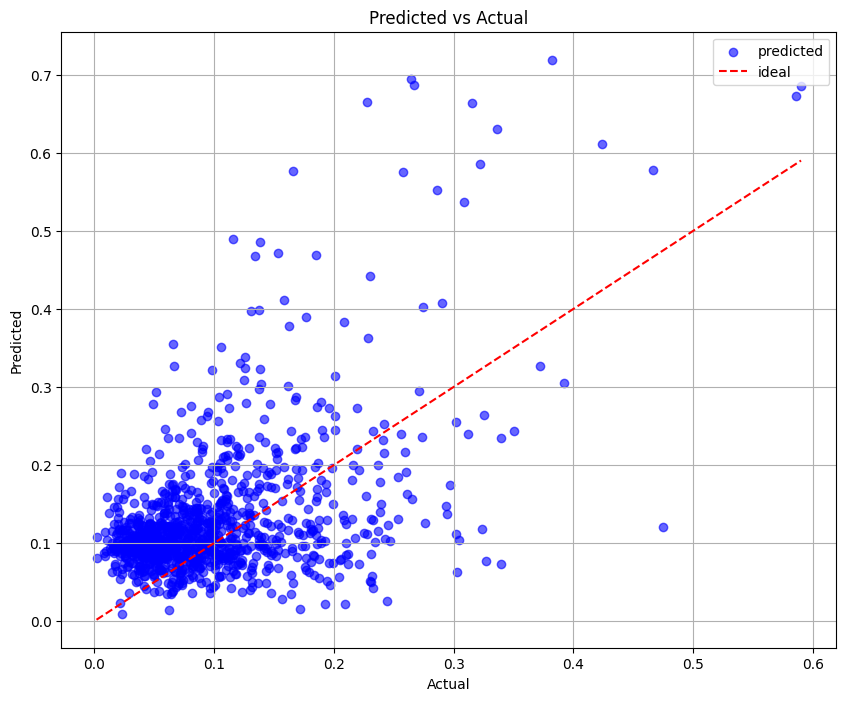

In [ ]:

plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred, alpha=0.6, color='blue', label="predicted")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label="ideal")
plt.title("Predicted vs Actual")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import randint, loguniform

import torch
import torch.nn as nn
from skorch import NeuralNetRegressor

df = pd.read_csv('../../data/dataV.csv', parse_dates=['Date'])
df.sort_values('Date', inplace=True, ignore_index=True)

df['Date_ordinal'] = df['Date'].apply(lambda dt: dt.toordinal())

# Feature & target
feature_cols = [
    'Date_ordinal', 'Inflation', 'CPI', 'Treasury_Yield', 'Close',
    'SP500_Adj_Close', 'Volume', 'GDP', 'mortage', 'unemployement',
    'fed_fund_rate', 'volatility', 'returns', 'EWMA_VM', 'GARCH_VM',
    'EGARCH_VM', 'RogersSatchell_VM', 'garman_klass', 'parkinson',
    'yang_zhang', 'move'
]

target_col = 'volatility_forcast'

X_raw = df[feature_cols].values
y_raw = df[[target_col]].values

scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X_raw)
y_scaled = scaler_y.fit_transform(y_raw)

# Sliding‑window sequences
def create_sequences(X, y, seq_len=20):
    Xs, ys = [], []
    for t in range(seq_len, len(X)):
        Xs.append(X[t-seq_len:t, :])
        ys.append(y[t, :])
    return np.asarray(Xs), np.asarray(ys)

SEQ_LEN = 20
X_seq, y_seq = create_sequences(X_scaled, y_scaled, SEQ_LEN)

class LSTMForecast(nn.Module):
    def __init__(self, input_dim=len(feature_cols), hidden_dim1=128, hidden_dim2=64):
        super().__init__()
        self.lstm1 = nn.LSTM(input_size=input_dim,
                             hidden_size=hidden_dim1,
                             num_layers=1,
                             batch_first=True)
        self.lstm2 = nn.LSTM(input_size=hidden_dim1,
                             hidden_size=hidden_dim2,
                             num_layers=1,
                             batch_first=True)
        self.fc = nn.Linear(hidden_dim2, 1)

    def forward(self, x):
        out1, _ = self.lstm1(x)
        out2, _ = self.lstm2(out1)
        return self.fc(out2[:, -1, :])



inner_param_dist = {
    'module__hidden_dim1': randint(32, 257),
    'module__hidden_dim2': randint(32, 129),
    'batch_size':          randint(32, 257),
    'optimizer__lr':       loguniform(1e-4, 1e-2),
}

test_size_candidates = [0.10, 0.20, 0.30, 0.40]



results = []
best_overall_mse = float('inf')
best_overall_details = None

for ts in test_size_candidates:
    split_idx = int((1 - ts) * len(X_seq))
    X_train, X_hold = X_seq[:split_idx], X_seq[split_idx:]
    y_train, y_hold = y_seq[:split_idx], y_seq[split_idx:]

    net = NeuralNetRegressor(
        module=LSTMForecast,
        module__input_dim=len(feature_cols),
        criterion=nn.MSELoss,
        optimizer=torch.optim.Adam,
        max_epochs=50,
        batch_size=128,          
        optimizer__lr=1e-3,  
        train_split=None,
        verbose=0,
        device='cuda' if torch.cuda.is_available() else 'cpu',
    )

    rs = RandomizedSearchCV(
        estimator=net,
        param_distributions=inner_param_dist,
        n_iter=20,
        cv=3,
        scoring='neg_mean_squared_error',
        random_state=42,
        verbose=0,
        n_jobs=-1,
    )

    rs.fit(X_train.astype(np.float32), y_train.astype(np.float32))

    # Evaluate best model on hold‑out slice
    best_model = rs.best_estimator_
    y_pred_scaled = best_model.predict(X_hold.astype(np.float32))
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1))
    y_true = scaler_y.inverse_transform(y_hold)

    mse  = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = max(0.0, r2_score(y_true, y_pred))

    results.append({
        'test_size' : ts,
        'best_inner_params': rs.best_params_,
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
    })

    if mse < best_overall_mse:
        best_overall_mse = mse
        best_overall_details = results[-1]

    print(f"test_size={ts:.2f}  |  hold‑out MSE={mse:.6f}  |  best inner params={rs.best_params_}")



print("\n================ BEST CONFIGURATION ================")
print(f"test_size         : {best_overall_details['test_size']}")
print(f"inner parameters  : {best_overall_details['best_inner_params']}")
print(f"Hold‑out MSE      : {best_overall_details['mse']:.6f}")
print(f"Hold‑out RMSE     : {best_overall_details['rmse']:.6f}")
print(f"Hold‑out MAE      : {best_overall_details['mae']:.6f}")
print(f"Hold‑out R²       : {best_overall_details['r2']:.4f}")


KeyboardInterrupt: 

## Option price model benchmark

### Base Black-Scholes

In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv('../../data/dataV.csv', parse_dates=['Date'])
df.sort_values('Date', inplace=True, ignore_index=True)

X_raw = df[['volatility', 'Close', 'Volume', 'returns', 'EWMA_VM', 'yang_zhang']].values    # (T, 1)
y_raw = df[['BS_30d_ATM_Call']].values  # (T, 1)

y_raw   # With normalization

array([[0.0288],
       [0.1102],
       [0.0434],
       ...,
       [0.1614],
       [0.117 ],
       [0.3856]])

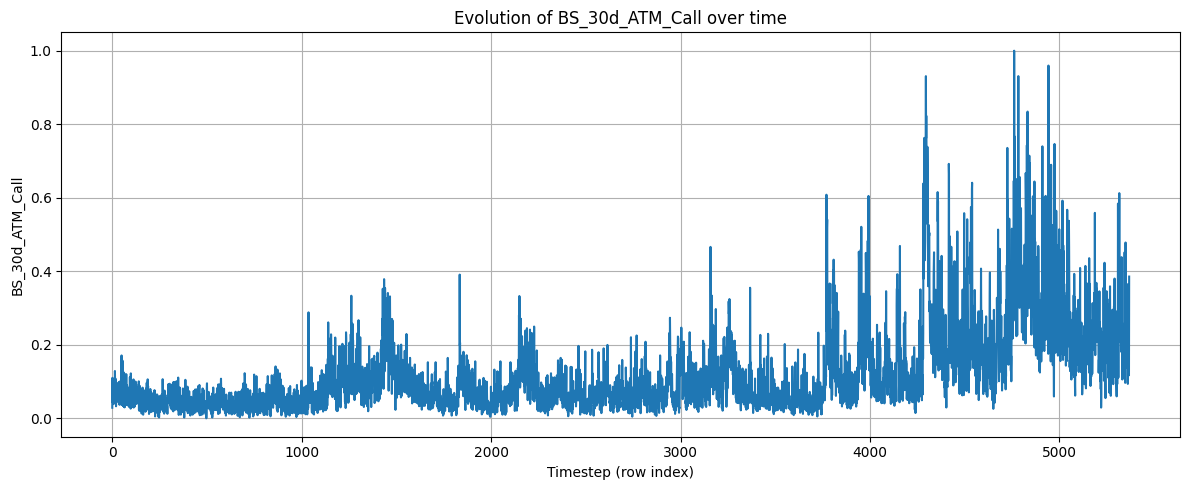

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(df.index, df['BS_30d_ATM_Call'])
plt.title('Evolution of BS_30d_ATM_Call over time')
plt.xlabel('Timestep (row index)')
plt.ylabel('BS_30d_ATM_Call')
plt.grid(True)
plt.tight_layout()
plt.show()


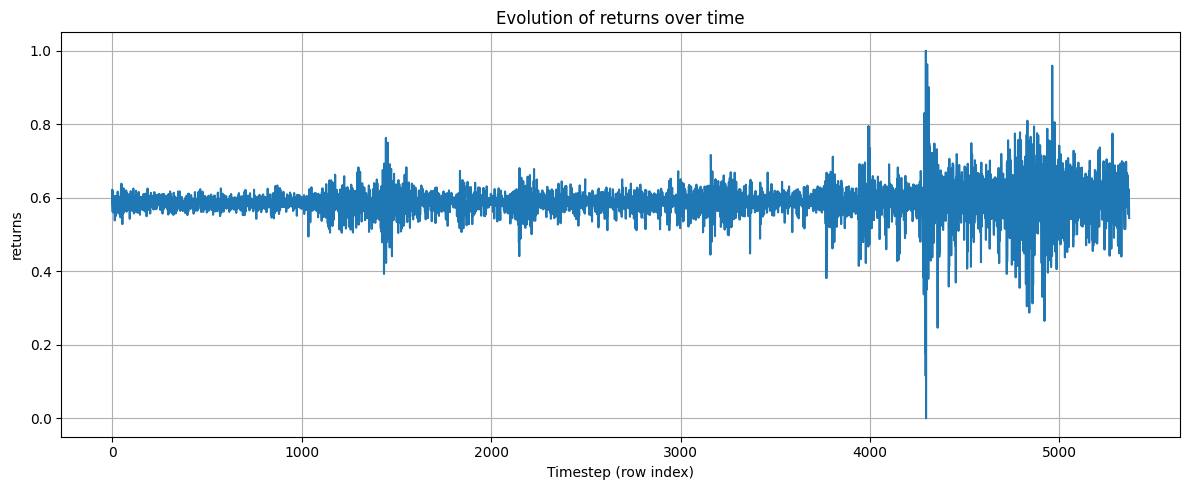

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(df.index, df['returns'])
plt.title('Evolution of returns over time')
plt.xlabel('Timestep (row index)')
plt.ylabel('returns')
plt.grid(True)
plt.tight_layout()
plt.show()


### Base LSTM

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# 1) Load & sort
df = pd.read_csv('../../data/dataV.csv', parse_dates=['Date'])
df.sort_values('Date', inplace=True, ignore_index=True)

X_raw = df[['volatility', 'Close', 'Volume', 'returns', 'EWMA_VM', 'yang_zhang']].values    # (T, 1)
y_raw = df[['BS_30d_ATM_Call']].values  # (T, 1)

# 2) Scale
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X_raw)
y_scaled = scaler_y.fit_transform(y_raw)

# 3) Build sequences
def create_sequences(X, y, seq_len):
    Xs, ys = [], []
    T = len(X)
    for t in range(seq_len, T):
        Xs.append(X[t-seq_len:t])
        ys.append(y[t])
    return np.array(Xs), np.array(ys)

SEQ_LEN = 20
X_seq, y_seq = create_sequences(X_scaled, y_scaled, SEQ_LEN)

# 4) Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_seq, test_size=0.2, shuffle=False
)

# 5) DataLoaders
batch_size = 32
train_loader = DataLoader(
    TensorDataset(torch.from_numpy(X_train).float(),
                  torch.from_numpy(y_train).float()),
    batch_size=batch_size, shuffle=True
)
test_loader = DataLoader(
    TensorDataset(torch.from_numpy(X_test).float(),
                  torch.from_numpy(y_test).float()),
    batch_size=batch_size, shuffle=False
)

# 6) Model
class LSTMForecast(nn.Module):
    def __init__(self, input_dim=8, hidden_dim=64, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim,
                            num_layers=num_layers,
                            batch_first=True)
        self.fc   = nn.Linear(hidden_dim, 1)
    def forward(self, x):
        out, _ = self.lstm(x)
        last = out[:, -1, :]
        return self.fc(last)

model     = LSTMForecast(input_dim=6, hidden_dim=64)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
model.lstm.dropout = 0.2

# 7) Train
n_epochs = 100
for epoch in range(1, n_epochs+1):
    model.train()
    total_loss = 0.0
    for Xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(Xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * Xb.size(0)
    print(f"Epoch {epoch}/{n_epochs} — train MSE: {total_loss/len(train_loader.dataset):.6f}")

# 8) Evaluate
model.eval()
preds, trues = [], []
with torch.no_grad():
    for Xb, yb in test_loader:
        p = model(Xb)
        preds.append(p.cpu().numpy())
        trues.append(yb.cpu().numpy())

y_pred_scaled = np.vstack(preds)
y_test_scaled = np.vstack(trues)

# Inverse-scale
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test = scaler_y.inverse_transform(y_test_scaled)

# Metrics
mse  = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)
#r2   = max(0.0, r2)

print(f"Test MSE : {mse:.6f}")
print(f"Test RMSE: {rmse:.6f}")
print(f"Test MAE : {mae:.6f}")
print(f"Test R²  : {r2:.4f}")


Epoch 1/100 — train MSE: 0.240296
Epoch 2/100 — train MSE: 0.156277
Epoch 3/100 — train MSE: 0.146135
Epoch 4/100 — train MSE: 0.142785
Epoch 5/100 — train MSE: 0.140621
Epoch 6/100 — train MSE: 0.139392
Epoch 7/100 — train MSE: 0.139262
Epoch 8/100 — train MSE: 0.137888
Epoch 9/100 — train MSE: 0.138510
Epoch 10/100 — train MSE: 0.136817
Epoch 11/100 — train MSE: 0.137430
Epoch 12/100 — train MSE: 0.137964
Epoch 13/100 — train MSE: 0.136576
Epoch 14/100 — train MSE: 0.136183
Epoch 15/100 — train MSE: 0.135244
Epoch 16/100 — train MSE: 0.135215
Epoch 17/100 — train MSE: 0.134201
Epoch 18/100 — train MSE: 0.134471
Epoch 19/100 — train MSE: 0.133046
Epoch 20/100 — train MSE: 0.133795
Epoch 21/100 — train MSE: 0.133070
Epoch 22/100 — train MSE: 0.131924
Epoch 23/100 — train MSE: 0.132684
Epoch 24/100 — train MSE: 0.131944
Epoch 25/100 — train MSE: 0.130546
Epoch 26/100 — train MSE: 0.130228
Epoch 27/100 — train MSE: 0.128979
Epoch 28/100 — train MSE: 0.129169
Epoch 29/100 — train MSE: 0.1

### EMD LSTM

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# 1) Load & sort
df = pd.read_csv('../../data/dataV.csv', parse_dates=['Date'])
df.sort_values('Date', inplace=True, ignore_index=True)


# 1b) DROP any row that has NaNs in the fields we’re about to use:
required_cols = [
    'vol_LSTM', 'Close', 'Volume',
    'returns', 'EWMA_VM', 'yang_zhang',
    'BS_30d_ATM_Call'
]
df = df.dropna(subset=required_cols).reset_index(drop=True)


X_raw = df[['vol_LSTM', 'Close', 'Volume', 'returns', 'EWMA_VM', 'yang_zhang']].values    # (T, 1)
y_raw = df[['BS_30d_ATM_Call']].values  # (T, 1)


# 2) Scale
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X_raw)
y_scaled = scaler_y.fit_transform(y_raw)

# 3) Build sequences
def create_sequences(X, y, seq_len):
    Xs, ys = [], []
    T = len(X)
    for t in range(seq_len, T):
        Xs.append(X[t-seq_len:t])
        ys.append(y[t])
    return np.array(Xs), np.array(ys)

SEQ_LEN = 20
X_seq, y_seq = create_sequences(X_scaled, y_scaled, SEQ_LEN)

# 4) Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_seq, y_seq, test_size=0.2, shuffle=False
)

# 5) DataLoaders
batch_size = 32
train_loader = DataLoader(
    TensorDataset(torch.from_numpy(X_train).float(),
                  torch.from_numpy(y_train).float()),
    batch_size=batch_size, shuffle=True
)
test_loader = DataLoader(
    TensorDataset(torch.from_numpy(X_test).float(),
                  torch.from_numpy(y_test).float()),
    batch_size=batch_size, shuffle=False
)

# 6) Model
class LSTMForecast(nn.Module):
    def __init__(self, input_dim=6, hidden_dim=64, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim,
                            num_layers=num_layers,
                            batch_first=True)
        self.fc   = nn.Linear(hidden_dim, 1)
    def forward(self, x):
        out, _ = self.lstm(x)
        last = out[:, -1, :]
        return self.fc(last)

model     = LSTMForecast(input_dim=6, hidden_dim=64)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
model.lstm.dropout = 0.2

# 7) Train
n_epochs = 100
for epoch in range(1, n_epochs+1):
    model.train()
    total_loss = 0.0
    for Xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(Xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * Xb.size(0)
    print(f"Epoch {epoch}/{n_epochs} — train MSE: {total_loss/len(train_loader.dataset):.6f}")

# 8) Evaluate
model.eval()
preds, trues = [], []
with torch.no_grad():
    for Xb, yb in test_loader:
        p = model(Xb)
        preds.append(p.cpu().numpy())
        trues.append(yb.cpu().numpy())

y_pred_scaled = np.vstack(preds)
y_test_scaled = np.vstack(trues)

# Inverse-scale
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test = scaler_y.inverse_transform(y_test_scaled)

# Metrics
mse  = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_test, y_pred)
r2   = r2_score(y_test, y_pred)
#r2   = max(0.0, r2)

print(f"Test MSE : {mse:.6f}")
print(f"Test RMSE: {rmse:.6f}")
print(f"Test MAE : {mae:.6f}")
print(f"Test R²  : {r2:.4f}")


Epoch 1/100 — train MSE: 0.864643
Epoch 2/100 — train MSE: 0.673234
Epoch 3/100 — train MSE: 0.616335
Epoch 4/100 — train MSE: 0.605161
Epoch 5/100 — train MSE: 0.599546
Epoch 6/100 — train MSE: 0.587147
Epoch 7/100 — train MSE: 0.584825
Epoch 8/100 — train MSE: 0.580999
Epoch 9/100 — train MSE: 0.574113
Epoch 10/100 — train MSE: 0.567660
Epoch 11/100 — train MSE: 0.571245
Epoch 12/100 — train MSE: 0.562954
Epoch 13/100 — train MSE: 0.567405
Epoch 14/100 — train MSE: 0.569510
Epoch 15/100 — train MSE: 0.552568
Epoch 16/100 — train MSE: 0.548097
Epoch 17/100 — train MSE: 0.544777
Epoch 18/100 — train MSE: 0.542080
Epoch 19/100 — train MSE: 0.548647
Epoch 20/100 — train MSE: 0.534982
Epoch 21/100 — train MSE: 0.541105
Epoch 22/100 — train MSE: 0.534756
Epoch 23/100 — train MSE: 0.542050
Epoch 24/100 — train MSE: 0.530024
Epoch 25/100 — train MSE: 0.522777
Epoch 26/100 — train MSE: 0.527134
Epoch 27/100 — train MSE: 0.516150
Epoch 28/100 — train MSE: 0.517363
Epoch 29/100 — train MSE: 0.5

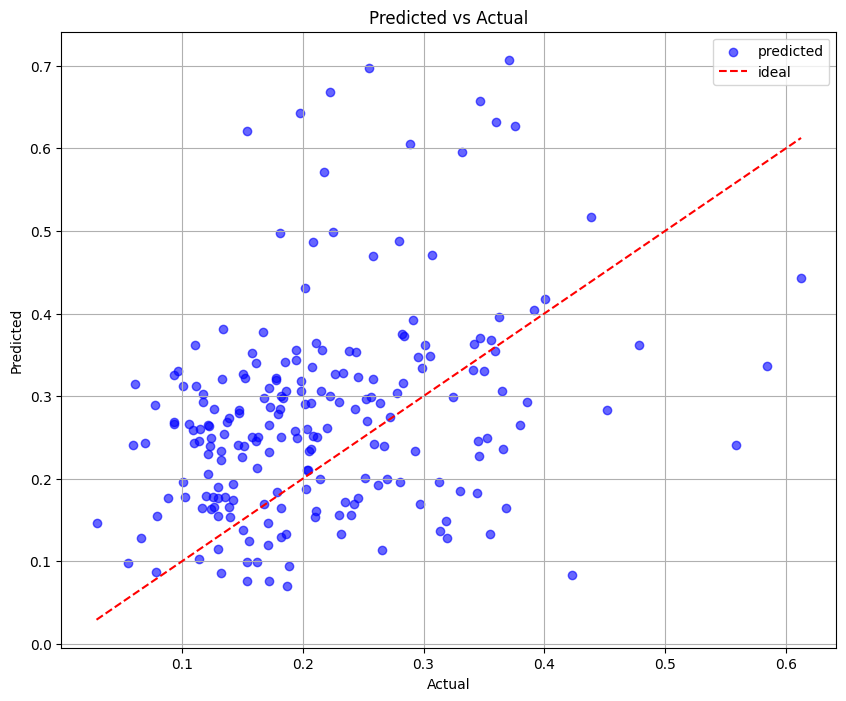

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred, alpha=0.6, color='blue', label="predicted")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label="ideal")
plt.title("Predicted vs Actual")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# ---------------------------------------------------------------
# Extra: compute R² (and regression line) with LinearRegression
# ---------------------------------------------------------------
from sklearn.linear_model import LinearRegression
import numpy as np

# Flatten the arrays to 1-D (shape = [n_samples,])
sigma      = y_test.ravel()   # true values
sigma_hat  = y_pred.ravel()   # predicted values

# Fit σ  = β₀ + β₁·σ_hat
linreg = LinearRegression()
linreg.fit(sigma_hat.reshape(-1, 1), sigma)

r_squared = linreg.score(sigma_hat.reshape(-1, 1), sigma)
beta_0    = linreg.intercept_      # scalar
beta_1    = linreg.coef_[0]        # slope

print(f"Linear-fit R² : {r_squared:.4f}")
print(f"β₀ (intercept): {beta_0:.6f}")
print(f"β₁ (slope)    : {beta_1:.6f}")


Linear-fit R² : 0.1044
β₀ (intercept): 0.144078
β₁ (slope)    : 0.257637
